# Projet 6 - Détectez des faux billets

## Partie I - Importation des données

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import P6_01b_OCR6 as OCR

from scipy.cluster.hierarchy import linkage, fcluster, cophenet, dendrogram

from sklearn import preprocessing
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
#from sklearn.metrics import silhouette_score, classification_report, confusion_matrix
from sklearn import metrics
from sklearn.model_selection import train_test_split

%matplotlib inline

sns.set(color_codes = True)
#sns.set(style="whitegrid")

In [2]:
_FONTSIZE_ = 18
_FONTSIZETITLE_ = 24
_HEADSIZE_ = 20

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (20, 10),
         'axes.labelsize': 'large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}

meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}

In [3]:
df = pd.read_csv('Data/notes.csv')
#df.loc[df['is_genuine'] == True, 'is_genuine'] = 1
#df.loc[df['is_genuine'] == False, 'is_genuine'] = 0

In [4]:
df_X = df.iloc[:, 1:]
df_Y = df.iloc[:, 0]

## Partie II - Analyse exploratoire

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    170 non-null    bool   
 1   diagonal      170 non-null    float64
 2   height_left   170 non-null    float64
 3   height_right  170 non-null    float64
 4   margin_low    170 non-null    float64
 5   margin_up     170 non-null    float64
 6   length        170 non-null    float64
dtypes: bool(1), float64(6)
memory usage: 8.3 KB


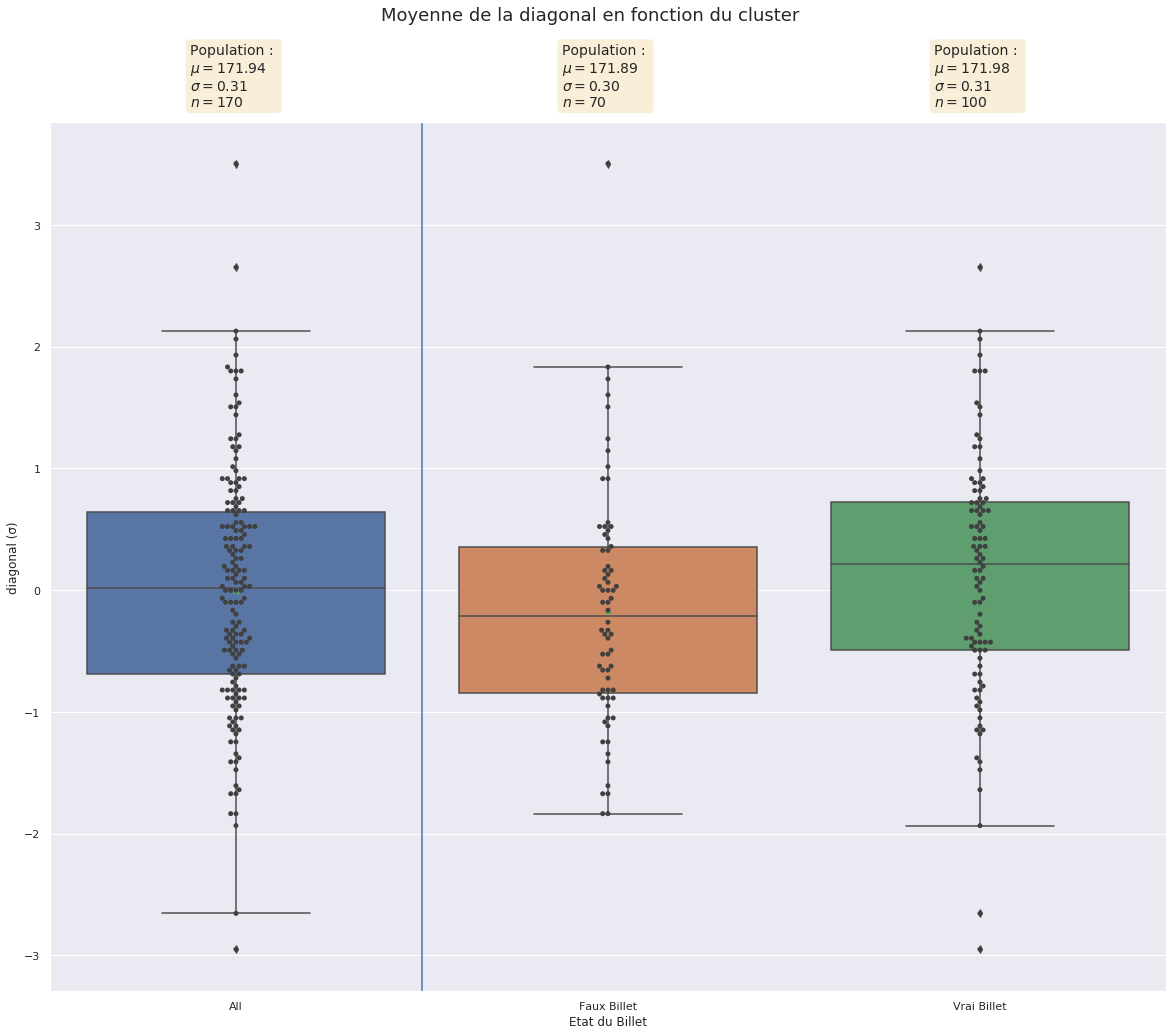

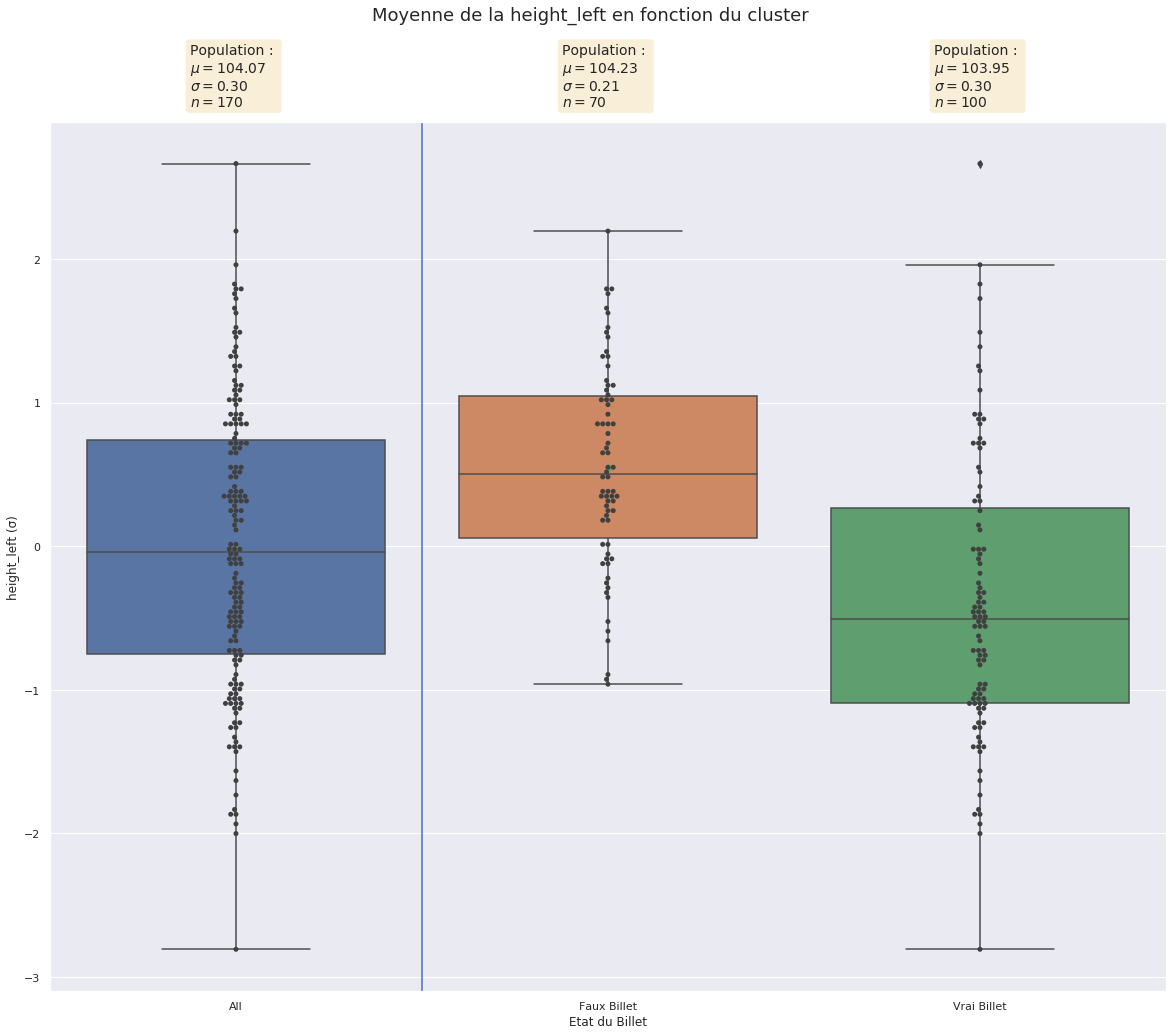

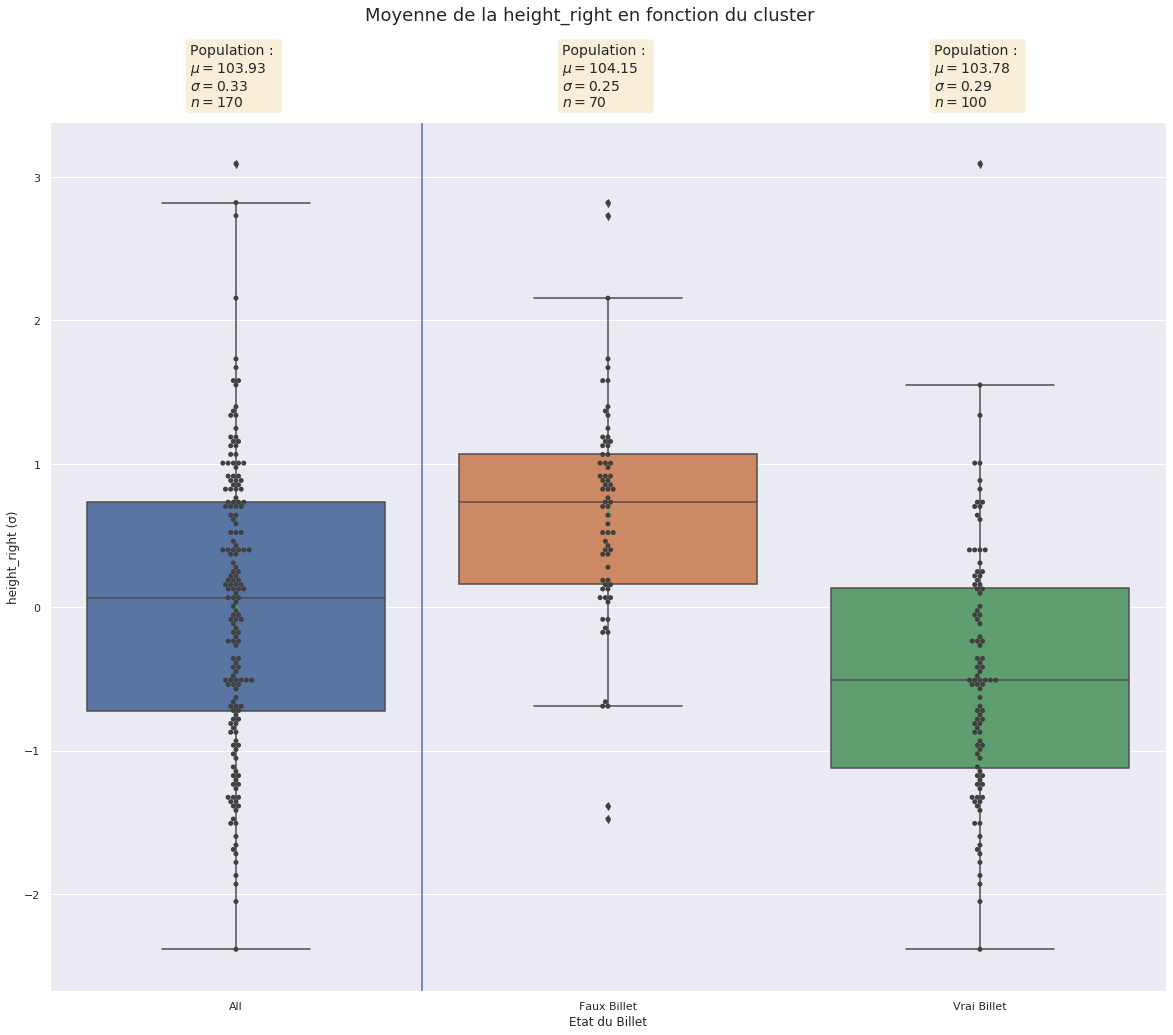

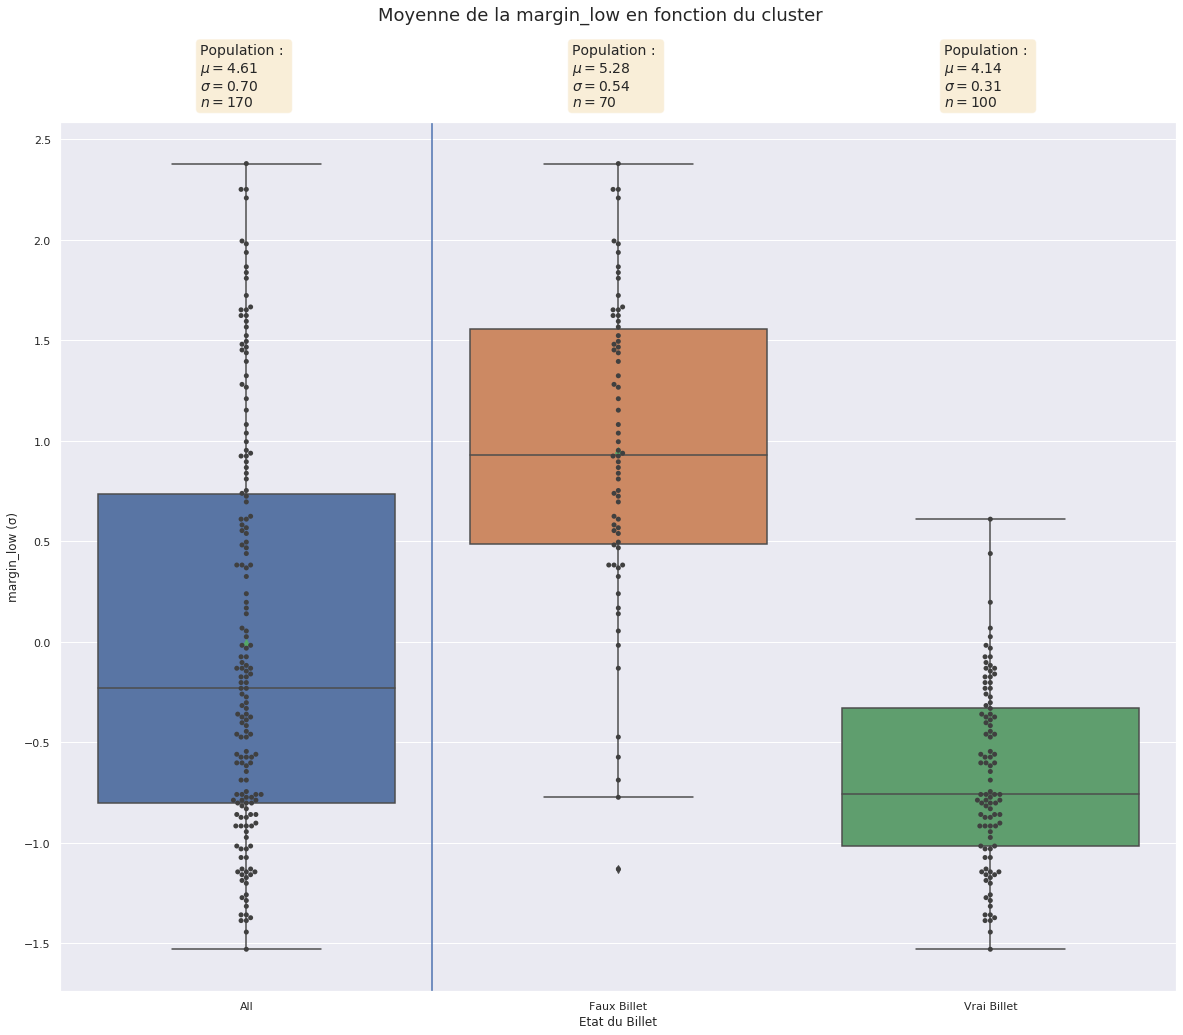

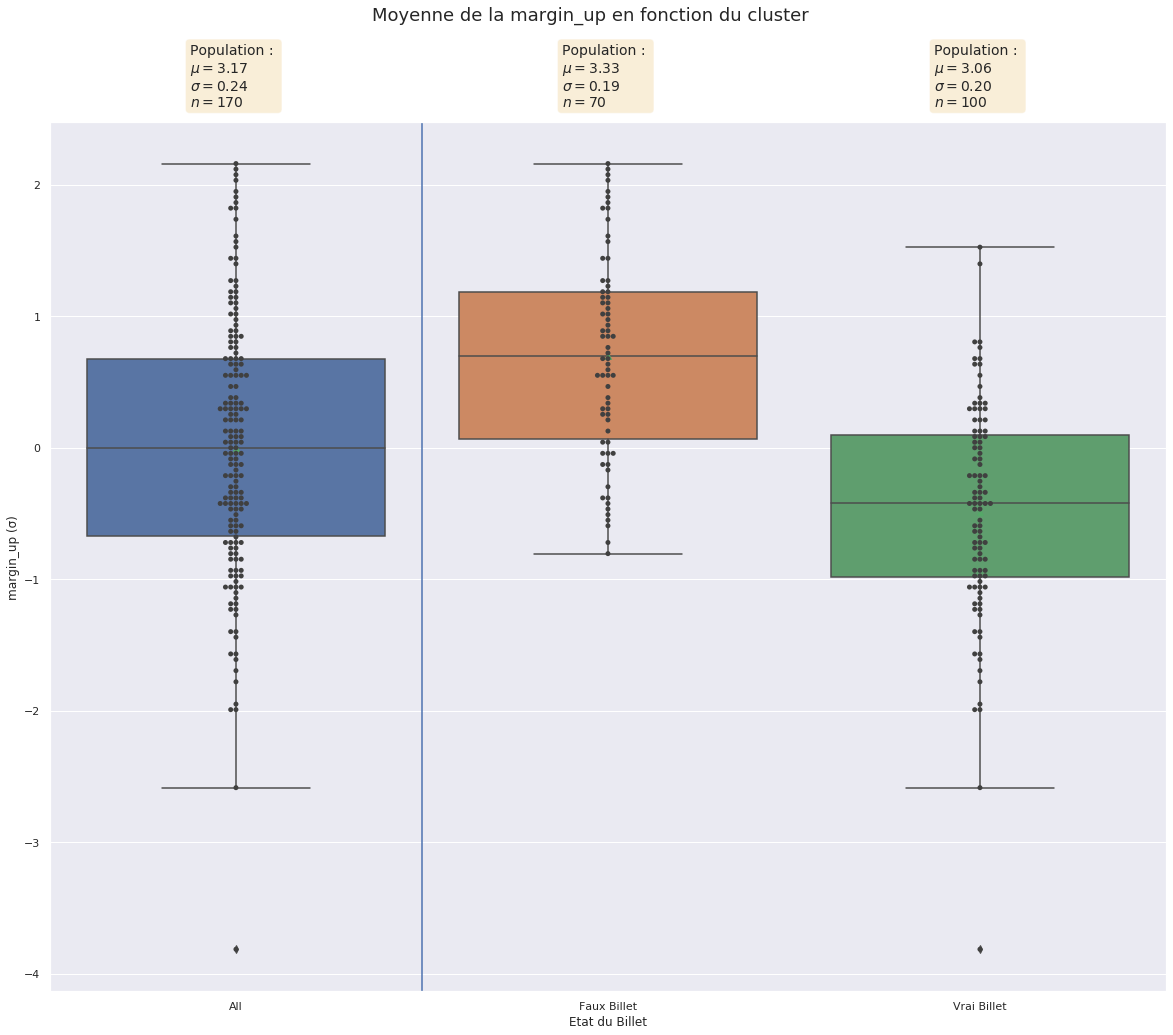

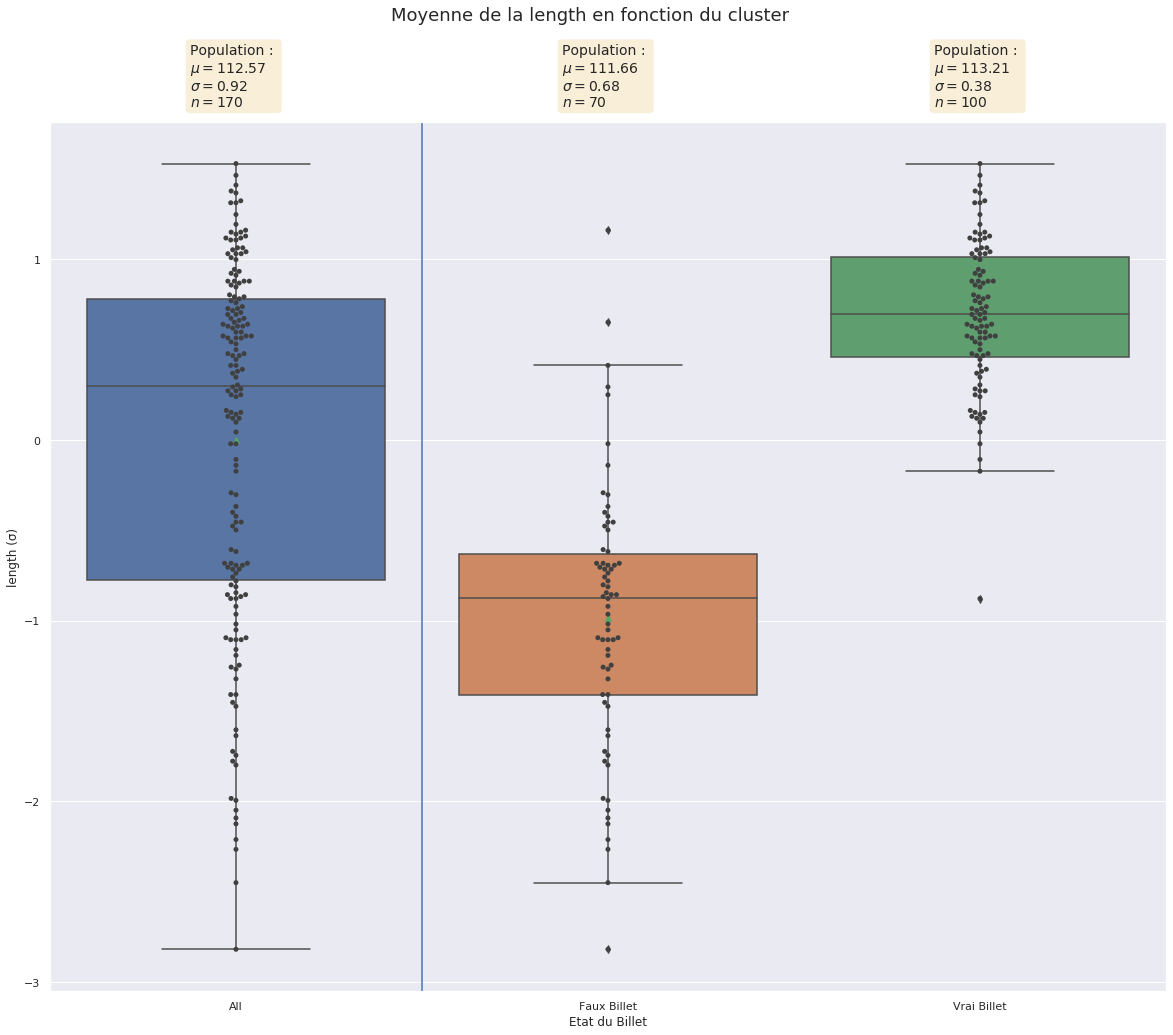

In [6]:
OCR.plotbox(df)

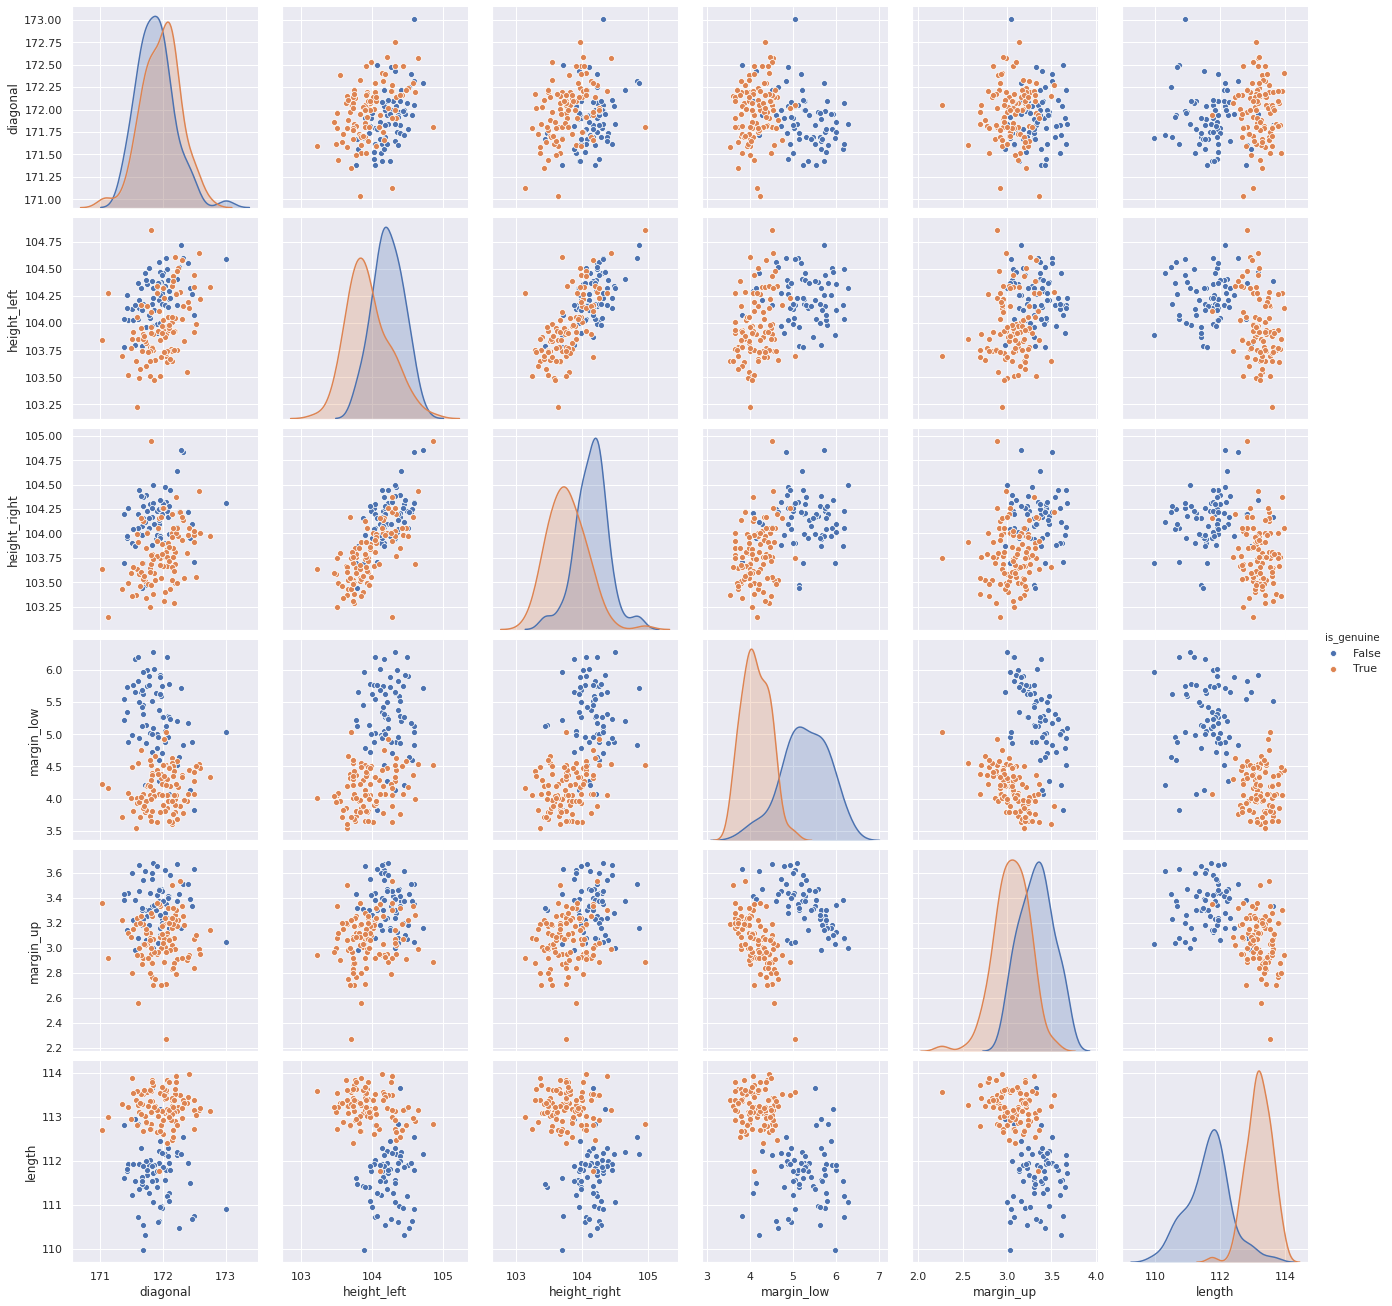

In [7]:
data_bivarie = pd.DataFrame(data=df)
sns.pairplot(df, hue='is_genuine', height=3)

plt.savefig('Images/carac_paires.png')

Nous pouvons remarquer que, pour les variables Margin_Low et Length, les deux types de billet, Vrai et Faux, se demarquent l'un de l'autre.

De plus, nous pouvons voir sur les scatter plots de ces deux variables que la délimitation des deux types de billets est assez franche.

#### Matrice de corrélation

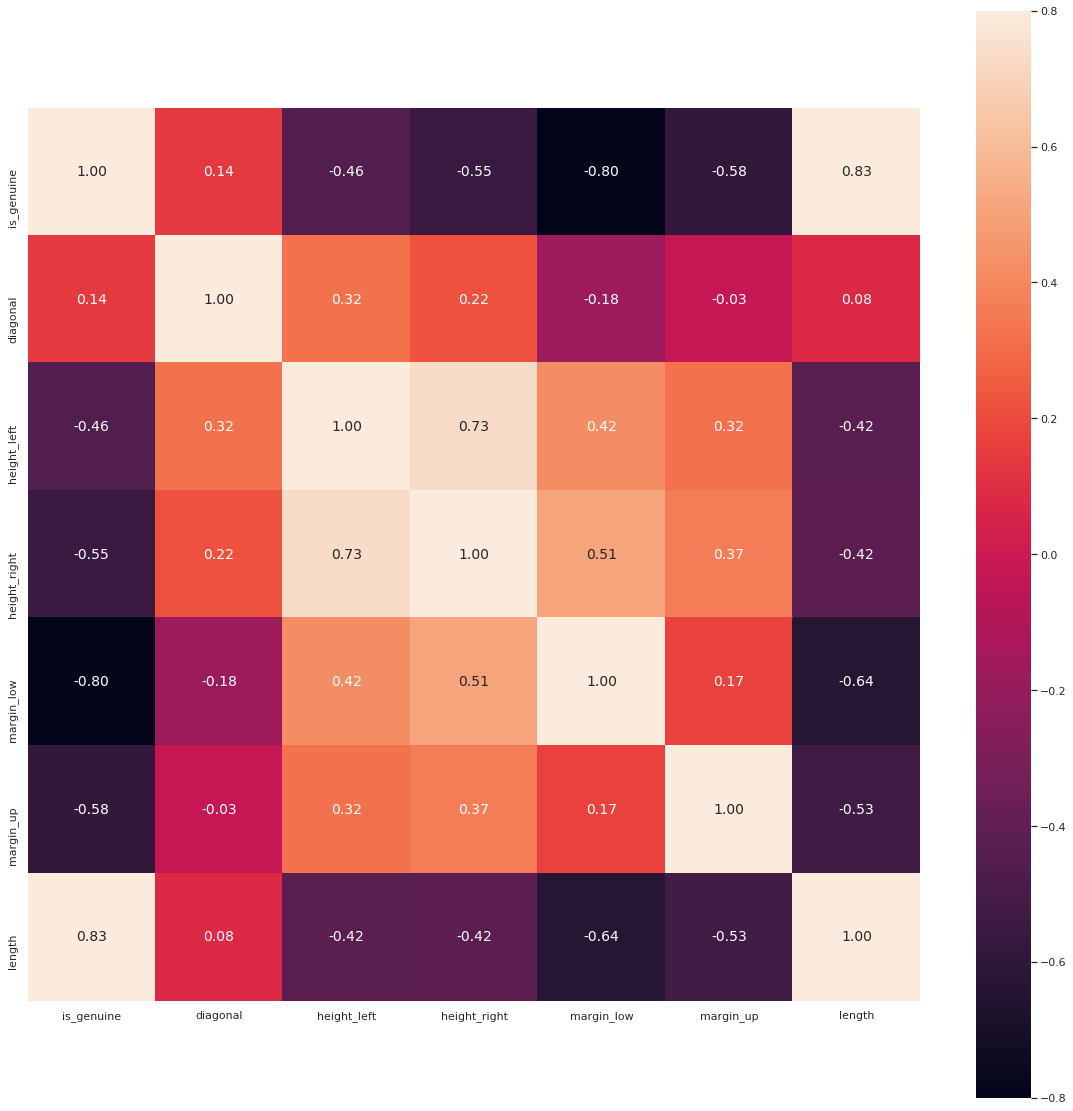

In [8]:
corrmat = df.corr()
fig, axes = plt.subplots(figsize = (20, 20))
sns.heatmap(corrmat, square=True, vmax=.8, vmin=-.8, annot=True,fmt='.2f', annot_kws={'size': 14});

Nous remarquons : 
* **une corrélation positive entre la longueur et la qualité du billet (vrai / faux billet)**
* **une corrélation négative entre margin_low et la qualité du billet (vrai / faux billet)**
* **une corrélation négative entre margin_up et height_right avec la qualité du billet (vrai / faux billet)**
* une corrélation positive entre height_right et height_left, ce qui est montre la forme rectangulaire du billet 
* une corrélation négative entre la longueur et margin_low
* une indépendence pour la diagonale en fonction de la longueur et de margin_up

## Partie III - Réalisation de l'ACP

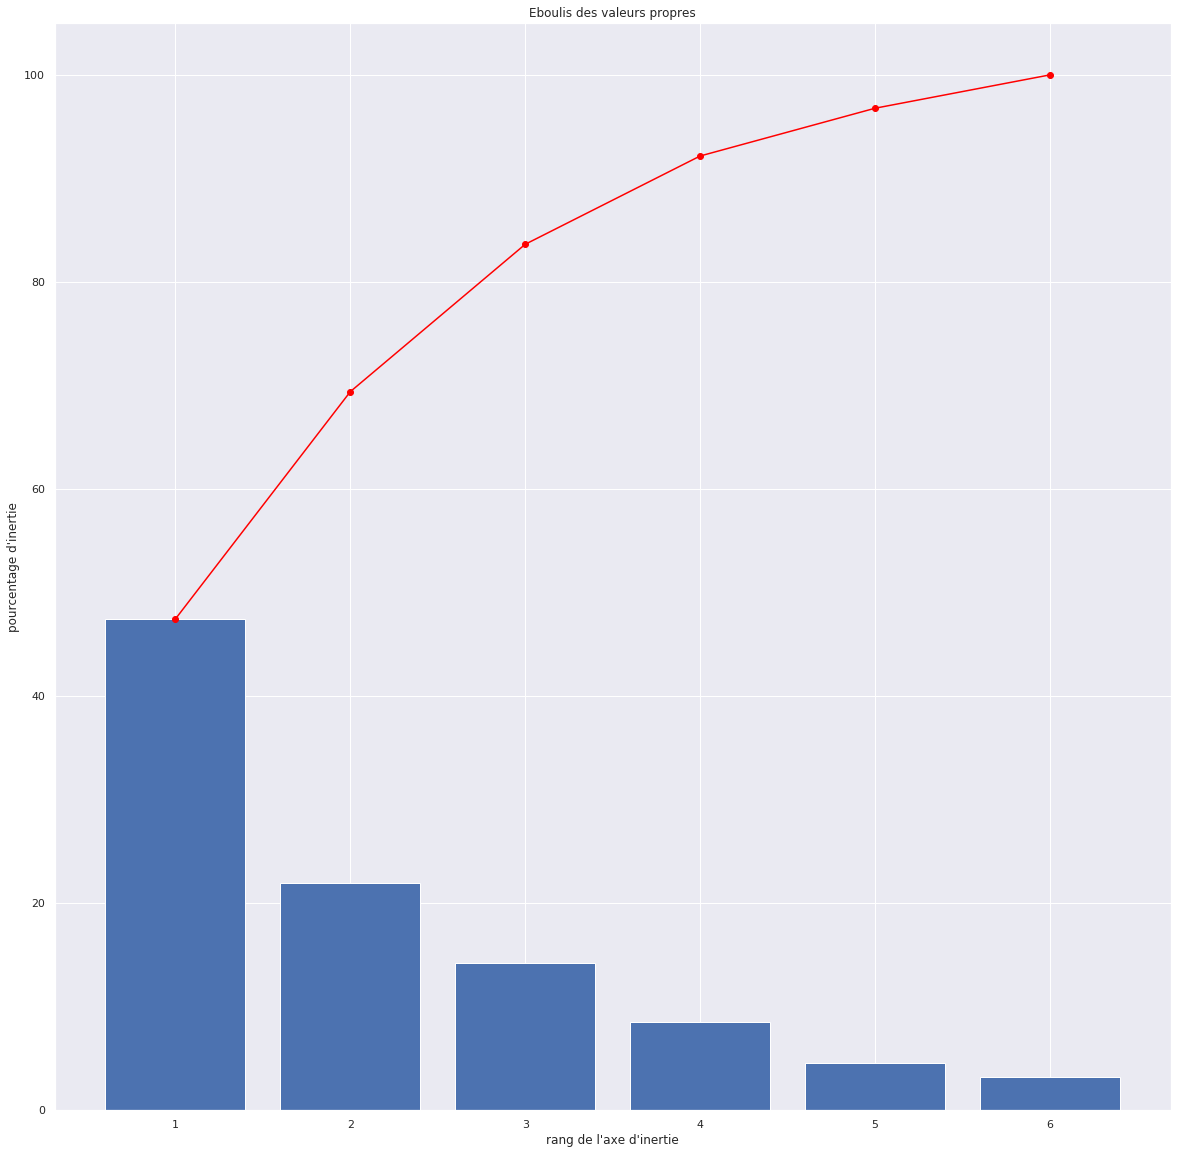

In [9]:
fig, axes = plt.subplots(figsize = (20, 20))

# choix du nombre de composantes à calculer
n_comp = 6

# selection des colonnes à prendre en compte dans l'ACP
data_pca = df[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']]

# préparation des données pour l'ACP
X = data_pca.values
names = data_pca.index #pour avoir les intitulés
features = data_pca.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

# Eboulis des valeurs propres
OCR.display_scree_plot(pca)
plt.show()

#### Affichage des valeurs propres

In [10]:
n = X_scaled.shape[0]
p = X_scaled.shape[1]

eigval = (n-1)/n*pca.explained_variance_

print(eigval)

[2.84687523 1.31742636 0.85407146 0.51157773 0.27676935 0.19327987]


La règle de Kaiser dit qu’un axe est intéressant si sa valeur propre est supérieure 1. Ici, nous pouvons prendre k = 2. Nous allons confirmer ce résultat par un autre test

#### Règle de Karlis – Saporta - Spinaki

In [11]:
karlis = 1 + 2 * np.sqrt((p-1) / (n-1))
f"Le seuil pour retenir un valeur propre est de {karlis:.2f} soit que la première valeur. La deuxième valeur propre étant proche, nous la prenons également"

'Le seuil pour retenir un valeur propre est de 1.34 soit que la première valeur. La deuxième valeur propre étant proche, nous la prenons également'

In [12]:
# choix du nombre de composantes à calculer
n_comp = 2

#### Cercles des corrélations et projection des individus

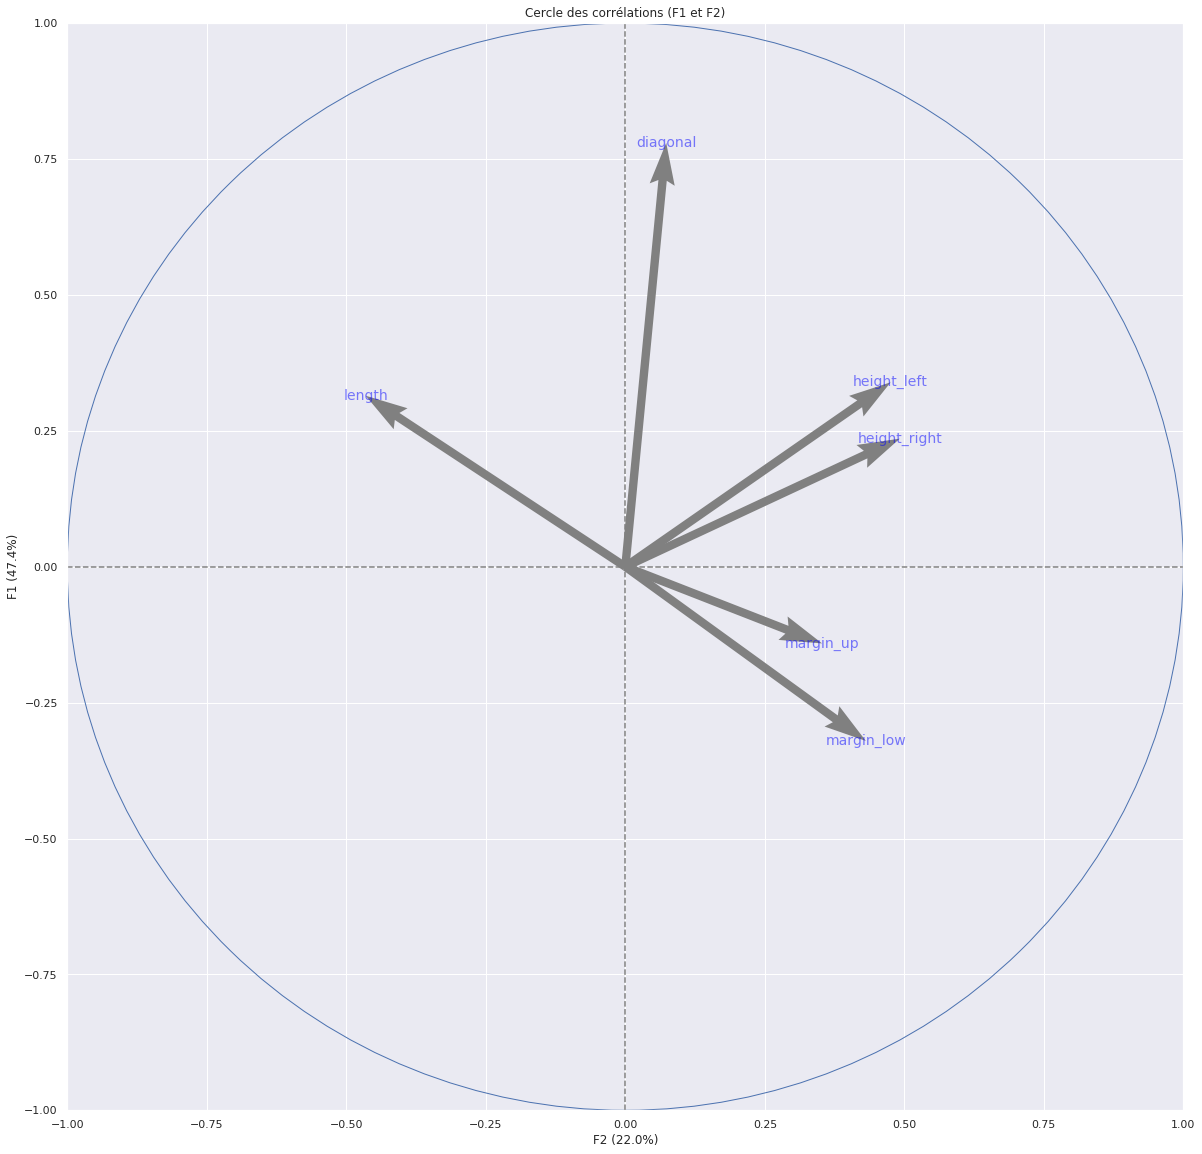

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


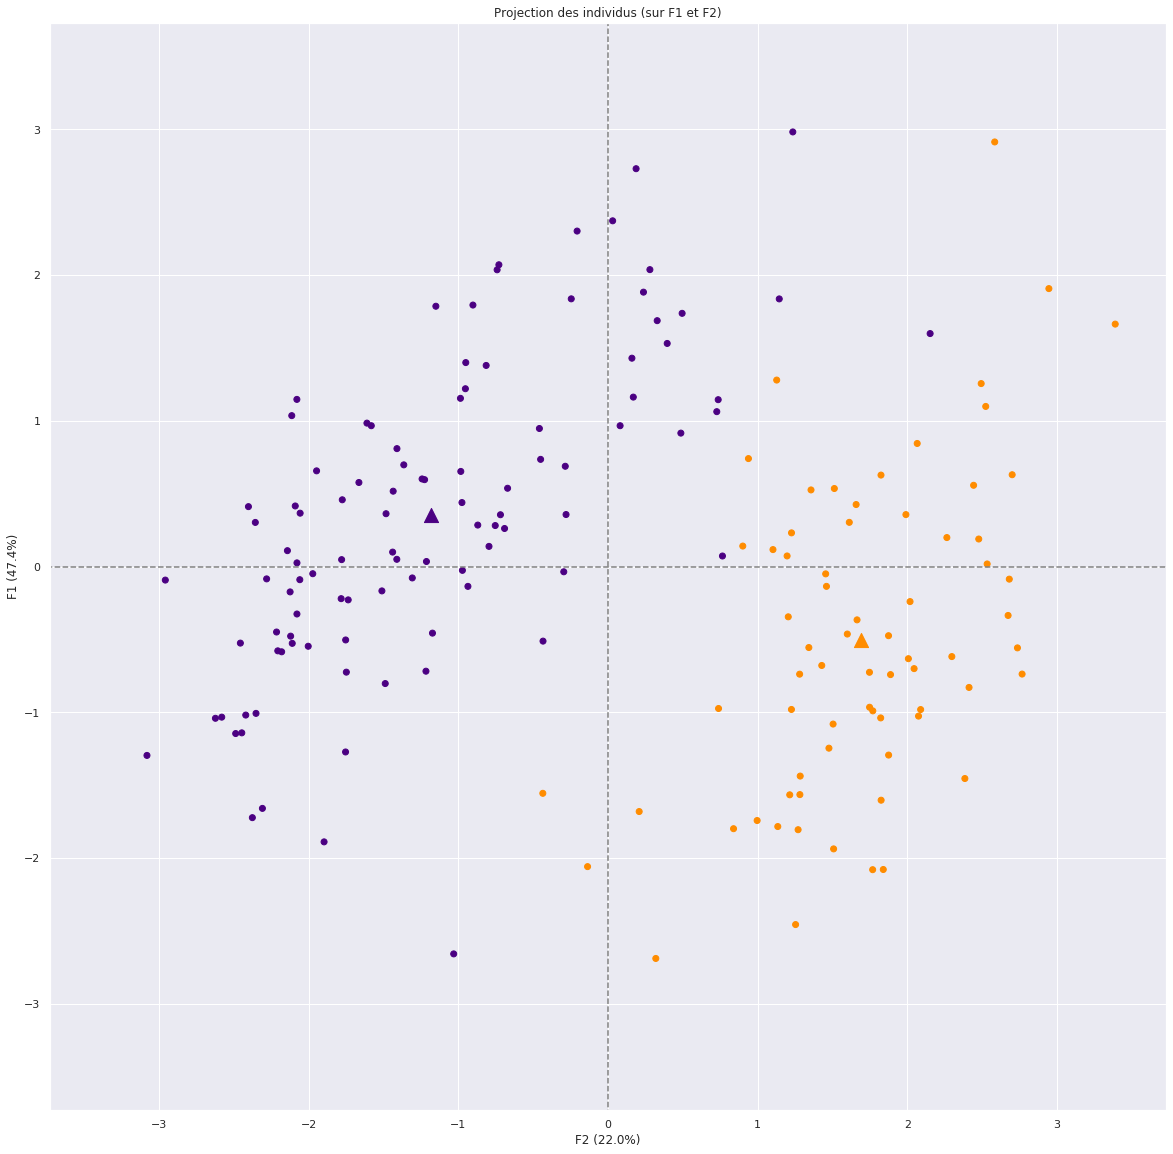

In [13]:
# Cercle des corrélations
pcs = pca.components_
OCR.display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features))

# Projection des individus
X_projected = pca.transform(X_scaled)
OCR.display_factorial_planes(X_projected, n_comp, pca, [(0,1)], df['is_genuine'].astype(int))#, labels = np.array(names))

#### Contribution des individus

In [14]:
#contribution des individus dans l'inertie totale
di = np.sum(X_scaled**2,axis=1)
df['d_i'] = di
df.sort_values('d_i', ascending=False).head(_HEADSIZE_)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,d_i
166,False,173.01,104.59,104.31,5.04,3.05,110.91,20.625650
0,True,171.81,104.86,104.95,4.52,2.89,112.83,18.410598
4,True,172.05,103.70,103.75,5.04,2.27,113.55,18.039567
122,False,172.29,104.72,104.86,5.71,3.16,112.15,16.790944
39,True,171.13,104.28,103.14,4.16,2.92,113.00,15.052608
112,False,172.32,104.60,104.83,4.84,3.51,112.55,14.422407
151,False,171.68,103.89,103.70,5.97,3.03,109.97,13.637281
49,True,171.59,103.23,103.64,4.01,2.94,113.59,12.917538
160,False,172.50,104.07,103.71,3.82,3.63,110.74,12.831169
158,False,171.84,104.32,104.50,6.28,3.00,111.06,12.724639


In [15]:
data_pca_di = df.sort_values('d_i', ascending=False).head(_HEADSIZE_)[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']]
X_di = data_pca_di.values

# Centrage et Réduction
std_scale_di = preprocessing.StandardScaler().fit(X_di)
X_scaled_di = std_scale_di.transform(X_di)

# Projection des individus
X_projected_di = pca.transform(X_scaled)
OCR.display_factorial_planes(X_projected_di, n_comp, pca, [(0,1)], df.sort_values('d_i', ascending=False).head(_HEADSIZE_)['is_genuine'].astype(int), labels = df.sort_values('d_i', ascending=False).head(_HEADSIZE_).index)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 170 and the array at index 1 has size 20

<Figure size 1440x1440 with 0 Axes>

array([[-0.42834385,  2.6694537 ,  3.09656321, -0.13159013, -1.18987367,
         0.28163308],
       [-0.88755932, -1.09769709, -0.69125444, -0.86012554, -1.27473985,
         0.78069736],
       [-0.36274164, -1.03042654, -0.50943919, -0.30301023, -1.23230676,
         1.37740465],
       ...,
       [ 1.73652911,  0.68497248,  0.52084721,  0.38267015,  0.67718214,
        -2.05094997],
       [-0.39554274, -0.32408577, -0.1458087 ,  0.16839504,  1.61071005,
        -0.75989238],
       [ 0.06367273, -0.22317994,  0.06630909,  1.45404575,  0.38015054,
        -1.74717171]])

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(20, 20))

fig.suptitle("Courbe de Lorenz en fonction des contributions à l'inertie totale de chaque individu", fontsize= _FONTSIZETITLE_)

lorenz, n, gini = OCR.lorenz(pd.DataFrame(data=df.sort_values('d_i')['d_i']))
xaxis = np.linspace(1/n,1+1/n,n+1) #Il y a un segment de taille n pour chaque individu, plus 1 segment supplémentaire d'ordonnée 0. Le premier segment commence à 0-1/n, et le dernier termine à 1+1/n.

axes.plot(xaxis,lorenz,drawstyle='steps-post')
axes.text(0.9, 0.6, f"Gini : {gini:0.2f}", {'color': 'C2', 'fontsize': 18}, va="center", ha="center")
axes.set_xlabel('Individu')
axes.set_ylabel('Inertie Total')

plt.show()

In [ ]:
f"Les {_HEADSIZE_} plus gros contributeurs representent {df.sort_values('d_i', ascending=False).head(_HEADSIZE_).sum().d_i / df.sort_values('d_i', ascending=False).sum().d_i * 100 :0.2f} % de l'inertie totale"

#### Qualité de représentation des individus - COS2

In [ ]:
cos2 = X_projected**2
for j in range(p):
    cos2[:,j] = cos2[:,j]/di

df['COS2_1'] = cos2[:,0]
df['COS2_2'] = cos2[:,1]
df['SumCOS2'] = df['COS2_1'] + df['COS2_2']
df.sort_values('SumCOS2', ascending=False).head(_HEADSIZE_)

In [ ]:
data_pca_CO2 = df.sort_values('SumCOS2', ascending=False).head(_HEADSIZE_)[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']]
X_CO2 = data_pca_CO2.values

# Centrage et Réduction
std_scale_CO2 = preprocessing.StandardScaler().fit(X_CO2)
X_scaled_CO2 = std_scale_CO2.transform(X_CO2)

# Projection des individus
X_projected_CO2 = pca.transform(X_scaled_CO2)
OCR.display_factorial_planes(X_projected_CO2, n_comp, pca, [(0,1)], df.sort_values('SumCOS2', ascending=False).head(_HEADSIZE_)['is_genuine'].astype(int), labels = df.sort_values('SumCOS2', ascending=False).head(_HEADSIZE_).index)

#### Contribution  des  individus  aux  axes

In [ ]:
ctr = X_scaled**2

for j in range(p):
    ctr[:,j] = ctr[:,j]/(n*eigval[j])

df['CTR_1'] = ctr[:,0]
df['CTR_2'] = ctr[:,1]
df.sort_values('CTR_1', ascending=False).head(_HEADSIZE_)

In [ ]:
data_pca_CTR_1 = df.sort_values('CTR_1', ascending=False).head(_HEADSIZE_)[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']]
X_CTR_1 = data_pca_CTR_1.values

# Centrage et Réduction
std_scale_CTR_1 = preprocessing.StandardScaler().fit(X_CTR_1)
X_scaled_CTR_1 = std_scale_CTR_1.transform(X_CTR_1)

# Projection des individus
X_projected_CTR_1 = pca.transform(X_scaled_CTR_1)
OCR.display_factorial_planes(X_projected_CTR_1, n_comp, pca, [(0,1)], df.sort_values('CTR_1', ascending=False).head(_HEADSIZE_)['is_genuine'].astype(int), labels = df.sort_values('CTR_1', ascending=False).head(_HEADSIZE_).index)

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(20, 20))

fig.suptitle("Courbe de Lorenz en fonction des contributions à l'axe F1 de chaque individu", fontsize= _FONTSIZETITLE_)

lorenz, n, gini = OCR.lorenz(pd.DataFrame(data=df.sort_values('CTR_1')['CTR_1']))
xaxis = np.linspace(1/n,1+1/n,n+1) #Il y a un segment de taille n pour chaque individu, plus 1 segment supplémentaire d'ordonnée 0. Le premier segment commence à 0-1/n, et le dernier termine à 1+1/n.

axes.plot(xaxis,lorenz,drawstyle='steps-post')
axes.text(0.85, 0.6, f"Gini : {gini:0.2f}", {'color': 'C2', 'fontsize': 18}, va="center", ha="center")
axes.set_xlabel('Individu')
axes.set_ylabel('Contribution Totale')

plt.show()

In [ ]:
f"Les {_HEADSIZE_} plus gros contributeurs representent {df.sort_values('CTR_1', ascending=False).head(_HEADSIZE_).sum().CTR_1 / df.sort_values('CTR_1', ascending=False).sum().CTR_1 * 100 :0.2f} % de la contribution totale"

In [ ]:
df.sort_values('CTR_2', ascending=False).head(_HEADSIZE_)

In [ ]:
data_pca_CTR_2 = df.sort_values('CTR_2', ascending=False).head(_HEADSIZE_)[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']]
X_CTR_2 = data_pca_CTR_2.values

# Centrage et Réduction
std_scale_CTR_2 = preprocessing.StandardScaler().fit(X_CTR_2)
X_scaled_CTR_2 = std_scale_CTR_2.transform(X_CTR_2)

# Projection des individus
X_projected_CTR_2 = pca.transform(X_scaled_CTR_2)
OCR.display_factorial_planes(X_projected_CTR_2, n_comp, pca, [(0,1)], df.sort_values('CTR_2', ascending=False).head(_HEADSIZE_)['is_genuine'].astype(int), labels = df.sort_values('CTR_2', ascending=False).head(_HEADSIZE_).index)

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(20, 20))

fig.suptitle("Courbe de Lorenz en fonction des contributions à l'axe F2 de chaque individu", fontsize= _FONTSIZETITLE_)

lorenz, n, gini = OCR.lorenz(pd.DataFrame(data=df.sort_values('CTR_2')['CTR_2']))
xaxis = np.linspace(1/n,1+1/n,n+1) #Il y a un segment de taille n pour chaque individu, plus 1 segment supplémentaire d'ordonnée 0. Le premier segment commence à 0-1/n, et le dernier termine à 1+1/n.

axes.plot(xaxis,lorenz,drawstyle='steps-post')
axes.text(0.8, 0.6, f"Gini : {gini:0.2f}", {'color': 'C2', 'fontsize': 18}, va="center", ha="center")
axes.set_xlabel('Individu')
axes.set_ylabel('Contribution Totale')

plt.show()

In [ ]:
f"Les {_HEADSIZE_} plus gros contributeurs representent {df.sort_values('CTR_2', ascending=False).head(_HEADSIZE_).sum().CTR_2 / df.sort_values('CTR_2', ascending=False).sum().CTR_2 * 100 :0.2f} % de la contribution totale"

#### Représentation des variables

In [ ]:
#racine carrée des valeurs propres
sqrt_eigval = np.sqrt(eigval)

In [ ]:
#corrélation des variables avec les axes
corvar = np.zeros((p,p))
for k in range(p):
    corvar[:,k] = pca.components_[k,:] * sqrt_eigval[k]

#on affiche pour les deux premiers axes
pd.DataFrame({'id':['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length'],'COR_1':corvar[:,0],'COR_2':corvar[:,1]})

#### Qualité  de  représentation  des  variables  (COS²)

In [ ]:
cos2var = corvar**2
pd.DataFrame({'id':['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length'],'COS2_1':cos2var[:,0],'COS2_2':cos2var[:,1]})

## Partie IV - Clustering

### Préparation des données - Centrage et Réduction

In [ ]:
# préparation des données pour le clustering
X = df_X.values
names = df_Y.index

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

### Validation du nombre de Cluster

In [ ]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    }

# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X_scaled)
    score = metrics.silhouette_score(X_scaled, kmeans.labels_)
    silhouette_coefficients.append(score)

In [ ]:
fig = plt.subplots(figsize = (20, 10))

plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

Nous constatons que le score de silhouette est maximal avec 2 clusters. Ce qui corresponds à la réalité du DataSet.

In [ ]:
__CLUSTER__ = 2

### Réalisation du clustering

In [ ]:
kmeans = KMeans(init='random', n_clusters=__CLUSTER__, n_init=10, max_iter=300).fit(df_X)

In [ ]:
df_X['clusters'] = kmeans.labels_

### Affichage et calcul de centroïde

In [ ]:
pd.DataFrame(kmeans.cluster_centers_, columns = [['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']])

### Réalisation de l'ACP

In [ ]:
# choix du nombre de composantes à calculer
n_comp = 6

# selection des colonnes à prendre en compte dans l'ACP

data_pca = df[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']]

# préparation des données pour l'ACP
X = data_pca.values
names = data_pca.index #pour avoir les intitulés
features = data_pca.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

In [ ]:
# Cercle des corrélations
pcs = pca.components_
OCR.display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features))

# Projection des individus
X_projected = pca.transform(X_scaled)
OCR.display_factorial_planes(X_projected, n_comp, pca, [(0,1)], df_X['clusters'].astype(int))#, labels

### Calcul de la precision

In [ ]:
f"La performance du clustering est de {df_X[df_X['clusters'] == df_Y]['clusters'].count() / df_X['clusters'].count() * 100:0.2f} % après {kmeans.n_iter_} itérations"

### Matrice de confusion

In [ ]:
cm = metrics.confusion_matrix(df_Y, df_X['clusters'])

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

## Partie V - Régression logistique

### Préparation des sets pour le clustering

In [ ]:
x = df_X.iloc[:, :-1].astype(int).values.reshape(-1,6)
y = df_Y.astype(int).values

In [ ]:
# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(x)
X_scaled = std_scale.transform(x)
#X_sclade = x

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)

### Entrainement du modèle

In [ ]:
model = LogisticRegression(solver='liblinear', multi_class='ovr').fit(x_train, y_train)

### Predication à l'aide du set de test

In [ ]:
y_pred = model.predict(x_test)

### Vérification de la performance

In [ ]:
model.score(x_train, y_train)

In [ ]:
model.score(x_test, y_test)

In [ ]:
cm = metrics.confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

In [ ]:
print(metrics.classification_report(y_test, y_pred))

In [ ]:
print(metrics.classification_report(y_test, y_pred))

In [ ]:
model.classes_

In [ ]:
model.intercept_

In [ ]:
model.coef_

In [ ]:
model.predict_proba(x)

In [ ]:
model.predict(x)

In [ ]:
model.score(x, y)

In [ ]:
metrics.confusion_matrix(y, model.predict(x))

In [ ]:
cm = metrics.confusion_matrix(y, model.predict(x))

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()


In [ ]:
print(metrics.classification_report(y, model.predict(x)))

In [ ]:
y_pred

In [ ]:
np.sqrt(metrics.mean_squared_error(y_test, y_pred))

In [ ]:
sizes = {} # clé : coordonnées ; valeur : nombre de points à ces coordonnées
for (yt, yp) in zip(list(y_test), list(y_pred)):
    if (yt, yp) in sizes:
        sizes[(yt, yp)] += 10
    else:
        sizes[(yt, yp)] = 10

        
fig, axes = plt.subplots(figsize = (20, 10))        
keys = sizes.keys()
plt.scatter(
        [k[0] for k in keys], # vraie valeur (abscisse)
        [k[1] for k in keys], # valeur predite (ordonnee)
        s=[sizes[k] for k in keys], # taille du marqueur
        color='steelblue', alpha =0.8)